In [7]:
import numpy as np
import pandas as pd
import datetime
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, r2_score
from sklearn.cluster import KMeans
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from nltk.stem.porter import *
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
def minmax(data, col):
    new_data = data
    max_num = np.max(new_data[:,col])
    min_num = np.min(new_data[:,col])

    for i in range(new_data.shape[0]):
        new_data[i][col] = (new_data[i][col] - min_num) / (max_num - min_num)
    
    return new_data

In [9]:
def makeData(n_samples=93240,n_features=11,dataPath="News_Final.csv"):
    data = pd.read_csv(dataPath)
    data["PublishDate"] = pd.to_datetime(data["PublishDate"], format="%Y-%m-%d %H:%M:%S")
    data['PublishDate'] = data['PublishDate'].apply(lambda x: time.mktime(x.timetuple()))
    data = data.to_numpy()
    
    labels = data[:n_samples,-3:]
    X = data[:n_samples,:-3]
    
    # omitting rows with no usable labels
    bool_matrix = np.any(labels != 0, axis=1)
    labels = labels[bool_matrix]
    X = X[bool_matrix]
    
    bool_matrix = labels[:, 1] != -1
    labels = labels[bool_matrix]
    X = X[bool_matrix]


    ### changing the lables 
    minmax(labels,0)
    minmax(labels,1)
    minmax(labels,2)
    minmax(X,5)

    Y_new = np.zeros(labels.shape[0])
    for i in range(labels.shape[0]):
        if labels[i][0] == -1 and labels[i][1] == -1 and labels[i][2] == -1:
            Y_new[i] = -1

        if labels[i][0] >= labels[i][1] and labels[i][0] >= labels[i][1]:
            Y_new[i] = 0
        elif labels[i][1] >= labels[i][0] and labels[i][1] >= labels[i][2]:
            Y_new[i] = 1
        elif labels[i][2] >= labels[i][1] and labels[i][2] >= labels[i][0]:
            Y_new[i] = 2

    labels = Y_new
    ###
    
    
    return X,labels

In [10]:
def splitData(X, labels, test_size, seed):
    np.random.seed(seed)
    
    indices = range(X.shape[0])
    train_indices = np.random.choice(indices,size = int(len(indices) * (1-test_size)),replace=False)
    test_indices = np.setdiff1d(indices,train_indices)
    
    X_train = X[train_indices]
    X_test = X[test_indices]  
    
    y_train = labels[train_indices]
    y_test = labels[test_indices]
    
    return X_train,X_test,y_train,y_test

In [11]:
from pandas.core.internals.blocks import final
class NewsData(object):
    def __init__(self):
        self.X, self.labels = makeData(5000)
        self.X_train, self.X_test, self.y_train, self.y_test = splitData(self.X,self.labels, 0.2, 2023)
        self.encoder = OneHotEncoder()
        self.vectorizer = TfidfVectorizer()
        self.tfidf = None
        self.corpus = []
        
    def OneHotEncodeTrain(self, index):
        col = np.array(self.X_train[:,index]).reshape(-1, 1)
        self.encoder.fit(col)
        one_hot_data = self.encoder.transform(col).toarray()
        for i in range(self.X_train.shape[0]):
            self.X_train[i][index] = list(one_hot_data[i])
            
    def OneHotEncodeTest(self, index):
        col = np.array(self.X_test[:,index]).reshape(-1, 1)
        self.encoder.fit(col)
        one_hot_data = self.encoder.transform(col).toarray()
        for i in range(self.X_test.shape[0]):
            self.X_test[i][index] = list(one_hot_data[i])
    
    def getCorpus(self, index):
        col = np.array(self.X_train[:,index]).reshape(-1, 1)
        col = [str(x) for x in col]

        row_strings = [''.join(row) for row in col]
        final_string = ''.join(row_strings)

        tokens = word_tokenize(final_string)

        stemmer = PorterStemmer()
        stemmed_tokens = [stemmer.stem(token) for token in tokens]

        final_string = np.unique(stemmed_tokens)

        self.corpus.append(final_string.tolist())

    def combineCorpus(self):
        i = 1
        while i < len(self.corpus):
            for x in self.corpus[i]:
                self.corpus[0].append(str(x))
            i+=1
        self.corpus = self.corpus[0]
        self.corpus = np.unique(self.corpus).tolist()
        self.corpus = pd.DataFrame(self.corpus, columns=['words'])

    def vectorizeTrain(self, index):
        if self.tfidf is None:
            self.tfidf = self.vectorizer.fit_transform(self.corpus['words'].values.astype('U'))
        for i in range(self.X_train.shape[0]):
            if type(self.X_train[i][index]) != type('str'):
                self.X_train[i][index] = ""
            self.X_train[i][index] = (self.vectorizer.transform([self.X_train[i][index]]))
    
    def vectorizeTest(self, index):
        if self.tfidf is None:
            self.tfidf = self.vectorizer.fit_transform(self.corpus['words'].values.astype('U'))
        for i in range(self.X_test.shape[0]):
            if type(self.X_test[i][index]) != type('str'):
                self.X_test[i][index] = ""
            self.X_test[i][index] = (self.vectorizer.transform([self.X_test[i][index]]))

        return self.tfidf.toarray()
    

    def makeCorpus(self, col_num):
        
        col_train = self.X_train[:, col_num]
        col_test = self.X_test[:, col_num]

        
        stemmer = PorterStemmer()
        for col in [col_train, col_test]:
            for sentence in col:
                words = word_tokenize(sentence.lower())
                stemmed_words = [stemmer.stem(word) for word in words]
                self.corpus.extend(stemmed_words)

        self.corpus = list(set(self.corpus))

    def get_top_words(self, numwords = 100):
        vectorizer = TfidfVectorizer()
        vectorizer.fit_transform([' '.join(self.corpus)])

        feature_names = list(vectorizer.vocabulary_.keys())
        tfidf_scores = vectorizer.transform([' '.join(self.corpus)])


        top_keywords_idx = tfidf_scores.toarray()[0].argsort()[::-1][:numwords]
        top_keywords = [feature_names[i] for i in top_keywords_idx]

        return top_keywords
    
    def count_top_words(self):

        top_keywords = self.get_top_words()

        count_train = np.zeros((self.X_train.shape[0], len(top_keywords)))
        count_test = np.zeros((self.X_test.shape[0], len(top_keywords)))

        for i, keyword in enumerate(top_keywords):


            for j, sentence in enumerate(self.X_train[:, 1]):
                words = word_tokenize(sentence.lower())
                stemmed_words = [PorterStemmer().stem(word) for word in words]
                count_train[j][i] = stemmed_words.count(keyword)


            for j, sentence in enumerate(self.X_train[:, 2]):
                words = word_tokenize(sentence.lower())
                stemmed_words = [PorterStemmer().stem(word) for word in words]
                count_train[j][i] += stemmed_words.count(keyword)


            for j, sentence in enumerate(self.X_test[:, 1]):
                words = word_tokenize(sentence.lower())
                stemmed_words = [PorterStemmer().stem(word) for word in words]
                count_test[j][i] += stemmed_words.count(keyword)

            
            for j, sentence in enumerate(self.X_test[:, 2]):
                words = word_tokenize(sentence.lower())
                stemmed_words = [PorterStemmer().stem(word) for word in words]
                count_test[j][i] += stemmed_words.count(keyword)

        self.X_train = np.concatenate((self.X_train, count_train), axis=1)
        self.X_test = np.concatenate((self.X_test, count_test), axis=1)

    

In [12]:
newsData = NewsData()
newsData.OneHotEncodeTrain(3)
newsData.OneHotEncodeTrain(4)

print("1")
newsData.OneHotEncodeTest(3)
newsData.OneHotEncodeTest(4)
print("2")
newsData.makeCorpus(1)
newsData.makeCorpus(2)
newsData.get_top_words(10)
newsData.count_top_words()
newsData.X_train = np.delete(newsData.X_train, 1, axis=1)
newsData.X_train = np.delete(newsData.X_train, 1, axis=1)
# np.concatenate((newsData.X_train, newsData.X_train[]), axis=1)
newsData.X_train = np.delete(newsData.X_train, 1, axis=1)
newsData.X_train = np.delete(newsData.X_train, 1, axis=1)
newsData.X_test = np.delete(newsData.X_test, 1, axis=1)
newsData.X_test = np.delete(newsData.X_test, 1, axis=1)
newsData.X_test = np.delete(newsData.X_test, 1, axis=1)
newsData.X_test = np.delete(newsData.X_test, 1, axis=1)

1
2


In [13]:
print(type(newsData.X_train))
print((newsData.y_train.shape))

kmeans_X_train = np.column_stack((newsData.X_train, newsData.y_train))
kmeans_X_test = np.column_stack((newsData.X_test, newsData.y_test))
print(kmeans_X_train)

<class 'numpy.ndarray'>
(2456,)
[[3437.0 0.8874523658137077 0.0 ... 0.0 0.0 1.0]
 [1699.0 0.372209005124491 0.0729166666666665 ... 0.0 0.0 0.0]
 [1388.0 0.31147052259702634 0.0441941738241592 ... 0.0 0.0 0.0]
 ...
 [2862.0 0.7360158661316198 0.125988157669742 ... 0.0 0.0 0.0]
 [3600.0 0.9179214020135839 -0.220970869120796 ... 0.0 0.0 0.0]
 [2532.0 0.6501282175445393 -0.0188444590361102 ... 0.0 0.0 0.0]]


In [14]:
trainarr = KMeans(n_clusters=3, random_state=0, n_init="auto").fit_transform(newsData.X_train)
testarr = KMeans(n_clusters=3, random_state=0, n_init="auto").fit_transform(newsData.X_test)
kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(trainarr)

In [15]:
from scipy.optimize import linear_sum_assignment
def evaluate_clustering(trained_model, X, labels):
    """
    Compute the ratio of correct matches between clusters from the trained model and the true labels
    :param trained_model: Unsupervised learning model that predicts clusters
    :param X: samples array, shape (num_samples, num_features)
    :param labels: true labels array, shape (num_samples,
    :return:
    """
    # We can assume that the number of clusters and the number of class labels are the same
    clusters = trained_model.predict(X)
    # Workspace 1.7
    #BEGIN 
    cost = np.zeros((np.unique(labels).shape[0],np.unique(labels).shape[0]))
    for x,y in np.column_stack((clusters.astype(int),labels.astype(int))):
        cost[x][y] -= 1
    #X mapping
    row_ind, col_ind = linear_sum_assignment(cost)
    accuracy = np.abs(cost[row_ind,col_ind].sum())/clusters.shape[0]
    
    
    #END
    return accuracy

(array([8., 1., 1., 3., 0., 0., 0., 0., 0., 7.]),
 array([0.35609756, 0.37252033, 0.38894309, 0.40536585, 0.42178862,
        0.43821138, 0.45463415, 0.47105691, 0.48747967, 0.50390244,
        0.5203252 ]),
 <BarContainer object of 10 artists>)

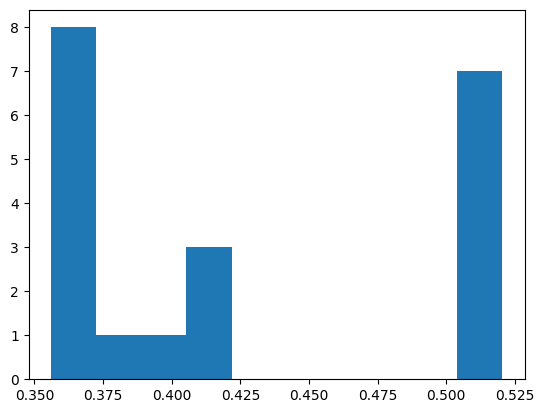

In [16]:
%matplotlib inline
accuracies = []
for i in range(20):
    trainarr = KMeans(n_clusters=3, n_init="auto").fit_transform(newsData.X_train)
    testarr = KMeans(n_clusters=3, n_init="auto").fit_transform(newsData.X_test)
    kmeans = KMeans(n_clusters=3, n_init="auto").fit(trainarr)
    accuracies.append(evaluate_clustering(kmeans, testarr, newsData.y_test))
plt.hist(accuracies)

In [20]:
import scipy

print("Mode:",scipy.stats.mode(accuracies))
print("Mean:",np.mean(accuracies))
print("Median:",np.median(accuracies))
print("Highest:",np.max(accuracies))
print("Lowest:",np.min(accuracies))

Mode: ModeResult(mode=array([0.5203252]), count=array([7]))
Mean: 0.4284552845528455
Median: 0.40731707317073174
Highest: 0.5203252032520326
Lowest: 0.35609756097560974


<ipython-input-20-76da8ec8a361>:3: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  print("Mode:",scipy.stats.mode(accuracies))
